In this post I'm going to show you my process for solving regression problems with XGBoost in python, using either the native `xgboost` API or the scikit-learn interface.
This is a  powerful methodology that can produce world class results in a short time with minimal thought or effort.
While we'll be working on an old Kagle competition for predicting the sale prices of bulldozers and other heavy machinery, you can use this flow to solve whatever tabular data regression problem you're working on.

This post serves as the explanation and documentation for  the
XGBoost regression jupyter notebook from my 
[ds-templates repo](https://github.com/mcb00/ds-templates)
on GitHub, so go ahead and download the notebook and follow along with your own data.

If you're not already comfortable with the ideas behind gradient boosting and XGBoost, you'll find it helpful to read some of my previous posts to get up to speed.
I'd start with this [introduction to gradient boosting](/posts/gradient-boosting-machine-from-scratch/),
and then read this [explanation of how XGBoost works](/posts/xgboost-explained/).

Let's get into it! 🚀



## Install and import the `xgboost` library

If you don't already have it, go ahead and [use conda to install the xgboost library](https://anaconda.org/conda-forge/xgboost), e.g.

```.zsh
$ conda install -c conda-forge xgboost
```

Then import it along with the usual suspects.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

## Read dataset into python

In this example we'll work on the 
[Kagle Bluebook for Bulldozers](https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview)
competition, which asks us to build a regression model to predict the sale price of heavy equipment.
Amazingly, you can solve your own regression problem by swapping this data out with your organization's data before proceeding with the tutorial.

Go ahead and download the `Train.zip` file from Kagle and extract it into `Train.csv`.
Then read the data into a pandas dataframe.

In [2]:
#| output: false
df = pd.read_csv('Train.csv', parse_dates=['saledate']);

/var/folders/p3/n6r4g5mj3m3dhls3j66tztmh0000gn/T/ipykernel_59038/374828784.py:2: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Train.csv', parse_dates=['saledate']);


Notice I cheated a little bit, checking the columns ahead of time and telling pandas to treat the `saledate` column as a date.
In general it will make life easier to read in any date-like columns as dates.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

## Prepare raw data for XGBoost

When faced with a new tabular dataset for modeling, we have two format considerations: data types and missingness.
From the call to `df.info()` above, we can see we have both mixed types and missing values.

When it comes to missing values, some models like the gradient booster or random forest in scikit-learn require purely non-missing inputs. 
One of the great strengths of XGBoost is that it relaxes this requirement, allowing us to pass in missing feature values, so we don't have to worry about them.

Regarding  data types, all ML models for tabular data require inputs to be numeric, either integers or floats, so we're going to have to deal with those `object` columns.



### Encode string features

The simplest way to encode string variables is to map each unique string value to an integer;
this is called *integer encoding*.

We can easily accomplish this by using the [categorical data type in pandas](https://pandas.pydata.org/docs/user_guide/categorical.html).
The category type is a bit like the factor type in R;
pandas stores the underlying data as integers, and it keeps a mapping from the integers back to the original string values.
XGBoost is able to access the numeric data underlying the categorical features for model training and prediction.
This is a nice way to encode string features because it's easy to implement and it preserves the original category levels in the data frame.
If you prefer to generate your own integer mappings, you can also do it with the scikit-learn
[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [4]:
def encode_string_features(df):
    out_df = df.copy()
    for feature, feature_type in df.dtypes.items():
        if feature_type == 'object':
            out_df[feature] = out_df[feature].astype('category')
    return out_df

df = encode_string_features(df)

### Encode date and timestamp features

While dates feel sort of numeric, they are not quite numbers, so we need to transform them  into numeric columns that XGBoost can understand.
Unfortunately, encoding timestamps isn't as straightforward as encoding strings, so we actually might need to engage in a little bit of feature engineering.
A single date has many different attributes, e.g. days since epoch, year, quarter, month, day, day of year, day of week, is holiday, etc.
Often a simple time index is the most useful information in a date column, so here we'll just start by adding a feature that gives the number of days since some epoch date.

In [77]:
df['saledate_days_since_epoch'] = (
    df['saledate'] - pd.Timestamp(year=1970, month=1, day=1)
    ).dt.days

### Transform the target if necessary

In the interest of speed and efficiency, we didn't bother doing any EDA with the feature data. Part of my justification for this is that trees are incredibly robust to outliers, colinearity, missingness, and other assorted nonsense in the feature data.
However, they are not necessarily robust to nonsense in the target variable, so it's worth having a look at it before proceeding any further.

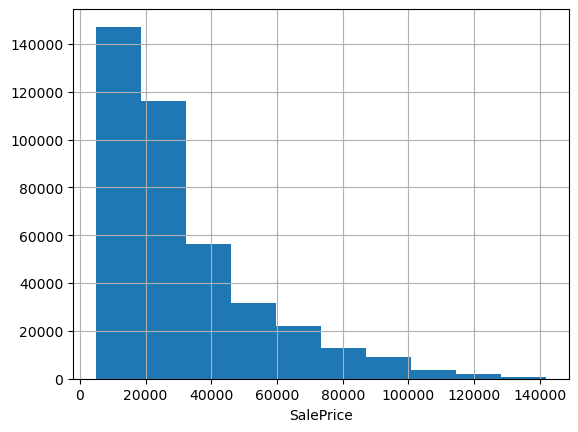

In [6]:
#| fig-alt: histogram of sale price showing right-skewed data
df.SalePrice.hist(); plt.xlabel('SalePrice');

Often when predicting prices it makes sense to use log price, especially when they span multiple orders of magnitude or have a strong right skew.
These data look pretty friendly, lacking outliers and exhibiting only a mild positive skew; we could probably get away without doing any transformation.
But checking the evaluation metric used to score the Kagle competition, we see they're using root mean squared log error.
That's equivalent to using RMSE on log-transformed target data, so let's go ahead and work with log prices.

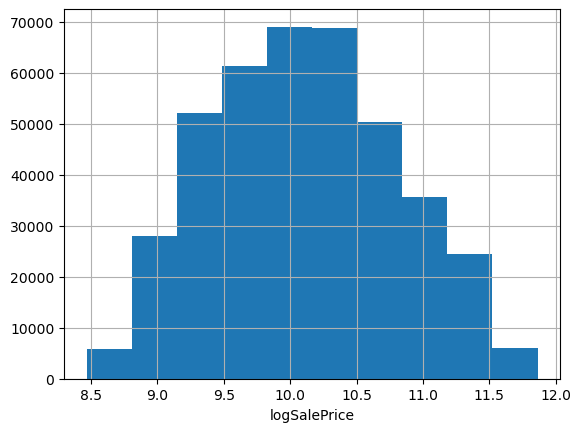

In [7]:
#| fig-alt: histogram of log sale price showing a more symetric distribution
df['logSalePrice'] = np.log1p(df['SalePrice'])
df.logSalePrice.hist(); plt.xlabel('logSalePrice');

## Train and Evaluate the XGBoost regression model

Having prepared our dataset, we are now ready to train an XGBoost model.
Let's walk through the flow step-by-step.

### Split the data into training and validation sets

First we split the dataset into a training set and a validation set.
Of course since we're going to evaluate against the validation set a number of times as we iterate, it's best practice to keep a separate test set reserved to check our final model to ensure it generalizes well.
Assuming that final test set is hidden away, we can use the rest of the data for training and validation.

There are two main ways we might want to select the validation set.
If there isn't a temporal ordering of the observations, we might be able to randomly sample.
In practice, it's common that observations have a temporal ordering, and that models are trained on observations up to a certain time and used to predict on observations occuring after that time.
Since this data is temporal, we don't want to split randomly; instead we'll split on observation date, reserving the latest observations for the validation set.

In [8]:
# Temporal Validation Set
def train_test_split_temporal(df, datetime_column, n_test):
    idx_sort = np.argsort(df[datetime_column])
    idx_train, idx_test = idx_sort[:-n_valid], idx_sort[-n_valid:]
    return df.iloc[idx_train, :], df.iloc[idx_test, :]

In [9]:
n_valid = 12000

train_df, valid_df = train_test_split_temporal(df, 'saledate', n_valid)
train_df.shape, valid_df.shape

((389125, 55), (12000, 55))


### Specify target and feature columns
Next we'll put together a list of our features and define the target column.
I like to have an actual list defined in the code so it's easy to explicitly see everything we're puting into the model and easier to add or remove features as we iterate.
Just run something like `list(df.columns)` in a cel to get a copy-pasteable list of columns, then edit it down to the full list of features, i.e. remove the target, date columns, and other non-feature columns..

In [10]:
#  list(df.columns)

In [11]:
features = [
    'SalesID',
    'MachineID',
    'ModelID',
    'datasource',
    'auctioneerID',
    'YearMade',
    'MachineHoursCurrentMeter',
    'UsageBand',
    'fiModelDesc',
    'fiBaseModel',
    'fiSecondaryDesc',
    'fiModelSeries',
    'fiModelDescriptor',
    'ProductSize',
    'fiProductClassDesc',
    'state',
    'ProductGroup',
    'ProductGroupDesc',
    'Drive_System',
    'Enclosure',
    'Forks',
    'Pad_Type',
    'Ride_Control',
    'Stick',
    'Transmission',
    'Turbocharged',
    'Blade_Extension',
    'Blade_Width',
    'Enclosure_Type',
    'Engine_Horsepower',
    'Hydraulics',
    'Pushblock',
    'Ripper',
    'Scarifier',
    'Tip_Control',
    'Tire_Size',
    'Coupler',
    'Coupler_System',
    'Grouser_Tracks',
    'Hydraulics_Flow',
    'Track_Type',
    'Undercarriage_Pad_Width',
    'Stick_Length',
    'Thumb',
    'Pattern_Changer',
    'Grouser_Type',
    'Backhoe_Mounting',
    'Blade_Type',
    'Travel_Controls',
    'Differential_Type',
    'Steering_Controls',
    'saledate_days_since_epoch'
 ]

target = 'logSalePrice'

### Create `DMatrix` data objects

XGBoost uses a data type called dense matrix for efficient training and prediction, so next we need to create `DMatrix` objects for our training and validation datasets.
Remember how we decided to encode our string columns by casting them as pandas categorical types?
For this to work, we need to set the `enable_categoricals` argument to `True`.

In [12]:
dtrain = xgb.DMatrix(data=train_df[features], label=train_df[target], 
                     enable_categorical=True)
dvalid = xgb.DMatrix(data=valid_df[features], label=valid_df[target], 
                     enable_categorical=True)

### Set the XGBoost parameters

XGBoost has [numerous hyperparameters](https://xgboost.readthedocs.io/en/latest/parameter.html).
Fortunately, just a handful of them tend to be the most influential; furthermore, the default values are not bad in most situations.
I like to start out with a dictionary containing the default  values for the parameters I'm most likely to adjust later, with one exception.
I dislike the default value of `auto` for the `tree_method` parameter, which tells XGBoost to choose a tree method on it's own.
I've been burned by this ambiguity in the past, so now I prefer to set it to `approx`.
For training there is one required boosting parameter called `num_boost_round` which I set to 50 as a starting point.

In [13]:
# default values for important parameters
params = {
    'tree_method': 'approx',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',
}
num_boost_round = 50

### Train the XGBoost model

The `xgb.train()` function takes our training dataset and parameters, and it returns a trained XGBoost model, which is an object of class `xgb.core.Booster`.
Check out the [documentation on the learning API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)
to see all the training options.
During training, I like to have XGBoost print out the evaluation metric on the train and validation set after every few boosting rounds and again at the end of training; that can be done by setting `evals` and `verbose_eval`.

In [14]:
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=10)

[0]	train-rmse:6.74240	valid-rmse:6.80825
[10]	train-rmse:0.31071	valid-rmse:0.34532
[20]	train-rmse:0.21950	valid-rmse:0.24364
[30]	train-rmse:0.20878	valid-rmse:0.23669
[40]	train-rmse:0.20164	valid-rmse:0.23254
[49]	train-rmse:0.19705	valid-rmse:0.23125


### Train the XGBoost model using the sklearn interface

If you prefer scikit-learn-like syntax, 
you can use the [sklearn estimator interface](https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html)
to create and train XGBoost models.
The `XGBRegressor` class, which is available in the `xgboost` library that we already imported, constructs an `XGBRegressor` object with `fit` and `predict` methods like you're used to using in scikit-learn. 
The `fit` and `predict` methods take pandas dataframes, so you don't need to create `DMatrix` data objects yourself; however, since these methods still have to transform input data into `DMatrix` objects internally, training and prediction seem to be slower via the sklearn interface.

In [15]:
# scikit-learn interface
reg = xgb.XGBRegressor(n_estimators=num_boost_round, enable_categorical=True, **params)
reg.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=10);

[0]	validation_0-rmse:6.74240	validation_1-rmse:6.80825
[10]	validation_0-rmse:0.31071	validation_1-rmse:0.34532
[20]	validation_0-rmse:0.21950	validation_1-rmse:0.24364
[30]	validation_0-rmse:0.20878	validation_1-rmse:0.23669
[40]	validation_0-rmse:0.20164	validation_1-rmse:0.23254
[49]	validation_0-rmse:0.19705	validation_1-rmse:0.23125


Since not all features of XGBoost are available through the scikit-learn estimator interface, you might want to get the native `xgb.core.Booster` object back out of the sklearn wrapper.

In [16]:
booster = reg.get_booster()

### Evaluate the XGBoost model and check for overfitting

We get the model evaluation metrics on the training and validation sets printed to stdout when we use the `evals` argument to the training API. 
Typically I just look at those printed metrics, but sometimes it's helpful to retain them in a variable for further inspection via, e.g. plotting.
To do that we need to train again, passing an empty dictionary to the `evals_result` argument.
In the objective curves, I'm looking for signs of overfitting, which could include validation scores staying the same or getting worse over later iterations or huge gaps between training and validation scores.



In [17]:
evals_result = {}
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=10,
                  evals_result=evals_result)

[0]	train-rmse:6.74240	valid-rmse:6.80825


[10]	train-rmse:0.31071	valid-rmse:0.34532
[20]	train-rmse:0.21950	valid-rmse:0.24364
[30]	train-rmse:0.20878	valid-rmse:0.23669
[40]	train-rmse:0.20164	valid-rmse:0.23254
[49]	train-rmse:0.19705	valid-rmse:0.23125


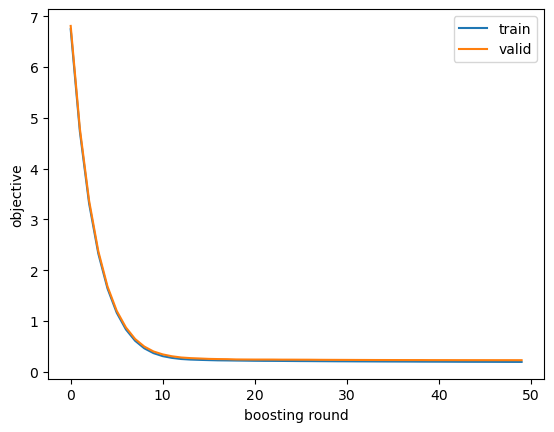

In [18]:
#| fig-alt: line plot showing objective function versus training iteration for training and validation sets
#| fig-cap: These objective curves look pretty good--no obvious signs of trouble.
pd.DataFrame({
    'train': evals_result['train']['rmse'],
    'valid': evals_result['valid']['rmse']
}).plot(); plt.xlabel('boosting round'); plt.ylabel('objective');

While we could just look at the validation RMSE in the printed output from model training,
let's go ahead and compute it by hand, just to be sure.

In [19]:
from sklearn.metrics import mean_squared_error

# squared=False returns RMSE
mean_squared_error(y_true=dvalid.get_label(), 
                   y_pred=model.predict(dvalid), 
                   squared=False)

0.23124987

So, how good is that RMSLE of 0.231?
Well, checking the 
[Kagle leaderboard](https://www.kaggle.com/competitions/bluebook-for-bulldozers/leaderboard) 
for this competition, we would have come in around 5th out of 474.
That's not bad for 10 minutes of work doing the bare minimum necessary to transform the raw data into a format consumable by XGBoost and then training a model using default hyperparameter values.
To improve our model from here we would want to explore some feature engineering and some hyperparameter tuning, which we'll save for another post.

> Wait, why was that so easy? 
Since XGBoost made it's big Kagle debut in the [2014 Higgs Boson competition](https://www.kaggle.com/c/higgs-boson),
presumably no one in this 2013 competition was using it yet.
A second potential reason is that we're using a different validation set from that used for the final leaderboard (which is long closed), but our score is likely still a decent approximation for how we would have done in the competition.

## XGBoost Model Interpretation

Next let's have a look at how to apply a couple of the most common
model interpretation techniques, feature importance and partial dependence, to XGBoost.

> Remember we have two trained models floating around: one called `model` of class `xgb.core.Booster` which is compatible with xgboost library utilities and another called `reg` of class `XGBRegressor` which is compatible with scikit-learn utilities. We need to be sure to use the model that's compatible with whatever utility we're using.

> While these interpretation tools are still very common, there's a newer, more comprehensive, and self-consistent model interpretation framework called [SHAP](https://shap.readthedocs.io/en/latest/) that's worth checking out.

### Feature Importance for XGBoost

While XGBoost automatically computes feature importance by three different metrics during training, you should only use them with great care and skepticism.
The three metrics are

- **weight**: the number of splits that use the feature
- **gain**: the average gain in the objective function from splits which use the feature
- **cover**: the average number of training samples affected by splits that use the feature

The first problem with these metrics is that they are computed using only the training dataset, which means they don't reflect how useful a feature is when predicting on out-of-sample data.
If your model is overfit on some nonsense feature, it will still have a high importance.
Secondly, I think they are difficult to interpret;
all three are specific to decision trees and reflect domain-irrelevant idiosyncrasies like whether a feature is used nearer the root or the leaves of a tree.
Anyway let's see what these metrics have to say about our features.

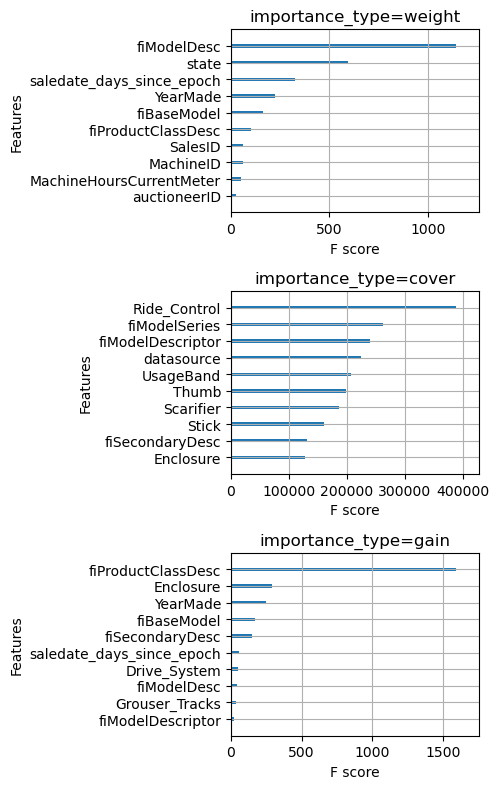

In [20]:
#| fig-alt: three horizontal bar plots showing feature importance for weight, cover, and gain metrics
#| fig-cap: top 10 features according to each built-in XGBoost feature importance metric

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 8))
xgb.plot_importance(model, importance_type='weight', title='importance_type=weight', 
                    max_num_features=10, show_values=False, ax=ax1, )
xgb.plot_importance(model, importance_type='cover', title='importance_type=cover', 
                    max_num_features=10, show_values=False, ax=ax2)
xgb.plot_importance(model, importance_type='gain', title='importance_type=gain', 
                    max_num_features=10, show_values=False, ax=ax3)
plt.tight_layout()

In [21]:
#| include: false
k=10
topk_weight = set(pd.Series(model.get_score(importance_type='weight')).sort_values(ascending=False).index[:k])
topk_cover = set(pd.Series(model.get_score(importance_type='cover')).sort_values(ascending=False).index[:k])
topk_gain = set(pd.Series(model.get_score(importance_type='gain')).sort_values(ascending=False).index[:k])
topk_weight.intersection(topk_cover), topk_weight.intersection(topk_gain), topk_cover.intersection(topk_gain), 

(set(),
 {'YearMade',
  'fiBaseModel',
  'fiModelDesc',
  'fiProductClassDesc',
  'saledate_days_since_epoch'},
 {'Enclosure', 'fiModelDescriptor', 'fiSecondaryDesc'})

Wow, notice that the top 10 features by weight and by cover are completely different.
This should forever cause you to feel skeptical whenever you see a feature importance plot.

Luckily, there is a better way.
IMHO, [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
 is better aligned with our intuition about what feature importance should mean.
It tells us by how much the model performance decreases when the values of a particular feature are randomly shuffled during prediction.
This effectively breaks the relationship between the feature and the target, thus revealing how much the model relies on that feature for prediction.
It also has the benefit that it can be computed using either training data or out-of-sample data.

In [75]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# make a scorer for RMSE
scorer = make_scorer(mean_squared_error, squared=False)
permu_imp = permutation_importance(reg, valid_df[features], valid_df[target], 
                                   n_repeats=30, random_state=0, scoring=scorer)

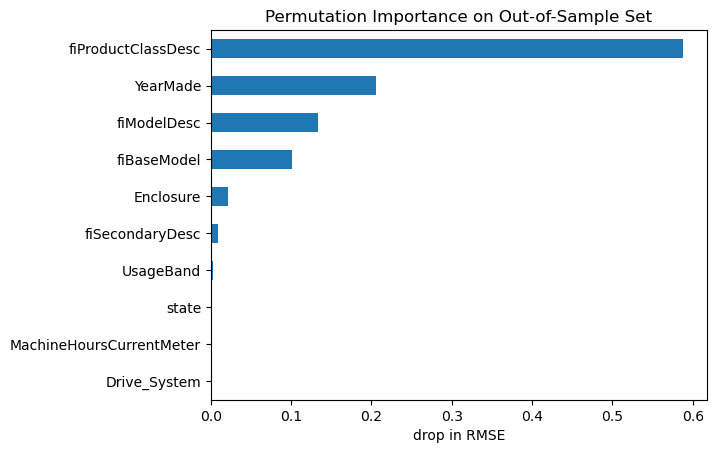

In [76]:
#| fig-alt: horizontal bar plot showing permutation feature importance
#| fig-cap: top 10 features by permutation importance on validation set

importances_permutation = pd.Series(-1 * permu_imp['importances_mean'], index=features)
importances_permutation.sort_values(ascending=True)[-10:].plot.barh()
plt.title('Permutation Importance on Out-of-Sample Set')
plt.xlabel('drop in RMSE');


Now we can see which features the model relies on most for out-of-sample predictions.
These are good candidate features to dig into with some EDA and conversations with any domain expert collaborators.

## Partial Dependence Plots for XGBoost

A [partial dependence plot (PDP)](https://scikit-learn.org/stable/modules/partial_dependence.html)
 is a representation of the dependence between the target variable and one or more feature variables.
We can loosely interpret it as showing how the expected value of the target changes across values of a particular feature, marginalizing over other features.
I say "loosely" because it comes with caveats, a particularly serious one being that correlation among features tends to invalidate the above interpretation.
Anyway, we can treat PDPs as useful heuristics for getting a sense of how a model thinks the target changes with feature values.

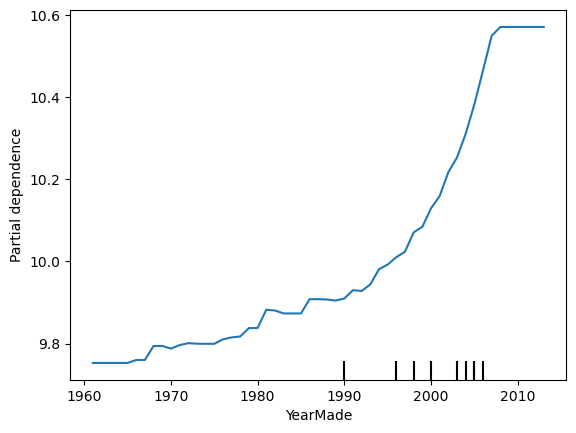

In [73]:
#| fig-alt: line plot showing partial dependence of logSalePrice on YearMade
#| fig-cap: PDP of target logSalePrice on feature YearMade
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(reg, 
                                        valid_df[features].query('YearMade >= 1960'), 
                                        ['YearMade']);

It looks like the log sale price tends to increase in a non-linear way with year made.

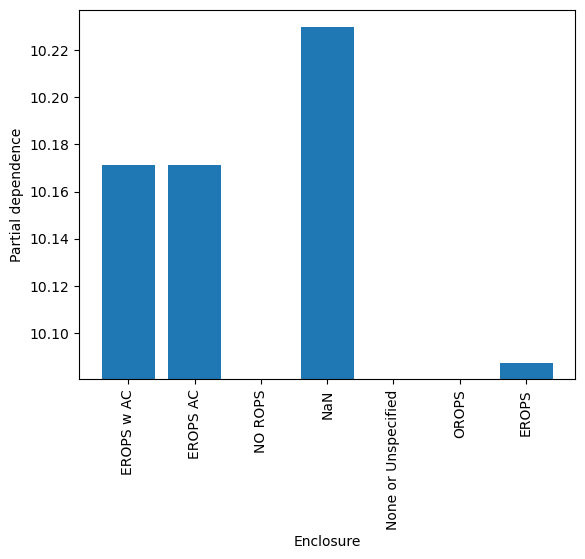

In [71]:
#| code-fold: true
#| fig-alt: bar plot showing partial dependence of logSalePrice on Enclosure
#| fig-cap: PDP of target logSalePrice on categorical feature Enclosure

# The PDPs for categorical features expect numeric data, not pandas categorical types,
# so the sklearn API for partial dependence won't work directly with the dataframe we've been using.
# The workaround is to create a new dataframe where categorical columns are encoded numerically,
# retrain the XGBoost model using the sklearn interface, create the PDPs,
# then add the category levels as the tick labels for the PDP.

def cat_pdp():
    cat_feature = 'Enclosure'
    modified_df = df.copy()
    cat_codes = modified_df[cat_feature].cat.codes
    cat_labels = list(modified_df[cat_feature].cat.categories)
    cat_labels = ['NaN'] + cat_labels if -1 in cat_codes.unique() else cat_labels
    modified_df[cat_feature] = cat_codes

    n_valid = 12000
    train_df, valid_df = train_test_split_temporal(modified_df, 'saledate', n_valid)
    train_df.shape, valid_df.shape

    # scikit-learn interface
    reg = xgb.XGBRegressor(n_estimators=num_boost_round, enable_categorical=True, **params)
    reg.fit(train_df[features], train_df[target], 
            eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
            verbose=0);
    PartialDependenceDisplay.from_estimator(reg, valid_df[features], [cat_feature], categorical_features=[cat_feature])
    plt.xticks(ticks=cat_codes.unique(), labels=cat_labels)
cat_pdp()

You can imagine how useful these model interpretation tools can be, both for understanding data and for improving your models.

## Wrapping Up

There you have it, a simple flow for solving regression problems with  XGBoost in python.
Remember you can use the XGBoost regression notebook from my [ds-templates repo](https://github.com/mcb00/ds-templates) 
to make it easy to follow this flow on your own problems.
If you found this helpful, or if you have additional ideas about solving regression problems with XGBoost, let me know down in the comments.